In [1]:
import tensorflow as tf


In [2]:
print(tf.__version__)

2.2.0


In [3]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

from sklearn.model_selection import train_test_split

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings



warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
data=pd.read_csv('favorites_sample_small.csv', delimiter=';',error_bad_lines=False)


In [6]:
data.head(10)

,user_id,favorited_at,id,organization_id,organization_active,organization_enabled,organization_display_id,import_on,import_software,organization_type,...,good_with_other_animals,good_with_others_notes,house_trained,altered,declawed,special_needs,shots_current,num_photos,num_aifs,num_videos
0,4369629,2020-01-01 00:00:04,46861637,44719,1,1,OH1073,0,NaN,Rescue Group / Foster-Based,...,unknown,NaN,0,1,0,1,1,5,11,0
1,4369629,2020-01-01 00:00:07,46898514,35651,1,1,OH745,0,NaN,Rescue Group / Foster-Based,...,unknown,NaN,0,1,0,0,1,2,0,0
2,4112169,2020-01-01 00:00:08,46980809,40518,1,1,NY1044,0,NaN,Rescue Group / Foster-Based,...,unknown,NaN,1,1,0,0,1,6,0,0
3,4369680,2020-01-01 00:00:12,46956517,29207,1,1,FL806,0,NaN,NaN,...,unknown,NaN,0,0,0,0,1,1,1,0
4,4369681,2020-01-01 00:00:13,46860620,48762,1,1,TN914,1,Petfinder Import Standard Template,Rescue Group / Foster-Based,...,unknown,NaN,0,0,0,0,0,3,26,0
5,4369629,2020-01-01 00:00:16,46898681,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,yes,foster has other dogs and cats,0,1,0,0,1,2,5,0
6,4369489,2020-01-01 00:00:17,46559227,26457,1,1,AR96,0,NaN,NaN,...,unknown,NaN,0,1,0,0,1,6,1,0
7,4369629,2020-01-01 00:00:17,46898698,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,yes,foster home has other dogs and cats,1,0,0,0,1,1,2,0
8,4369629,2020-01-01 00:00:18,46898687,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,yes,foster has other dogs and cats,0,1,0,0,1,1,3,0
9,4369682,2020-01-01 00:00:20,46934463,42387,1,1,NC823,0,NaN,NaN,...,unknown,NaN,0,0,0,0,1,6,2,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140969 entries, 0 to 140968
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         140969 non-null  int64  
 1   favorited_at                    140969 non-null  object 
 2   id                              140969 non-null  int64  
 3   organization_id                 140969 non-null  int64  
 4   organization_active             140969 non-null  int64  
 5   organization_enabled            140969 non-null  int64  
 6   organization_display_id         140969 non-null  object 
 7   import_on                       140969 non-null  int64  
 8   import_software                 61836 non-null   object 
 9   organization_type               109264 non-null  object 
 10  location_type                   140969 non-null  object 
 11  is_public_location              140969 non-null  int64  
 12  state_code      

In [8]:
data['Description_Flag'] = np.where(data['pet_description'].notnull(), 1, 0)



In [9]:
data['organization_type'].fillna("Unknown", inplace = True) 

In [10]:
data.head(10)

,user_id,favorited_at,id,organization_id,organization_active,organization_enabled,organization_display_id,import_on,import_software,organization_type,...,good_with_others_notes,house_trained,altered,declawed,special_needs,shots_current,num_photos,num_aifs,num_videos,Description_Flag
0,4369629,2020-01-01 00:00:04,46861637,44719,1,1,OH1073,0,NaN,Rescue Group / Foster-Based,...,NaN,0,1,0,1,1,5,11,0,1
1,4369629,2020-01-01 00:00:07,46898514,35651,1,1,OH745,0,NaN,Rescue Group / Foster-Based,...,NaN,0,1,0,0,1,2,0,0,1
2,4112169,2020-01-01 00:00:08,46980809,40518,1,1,NY1044,0,NaN,Rescue Group / Foster-Based,...,NaN,1,1,0,0,1,6,0,0,1
3,4369680,2020-01-01 00:00:12,46956517,29207,1,1,FL806,0,NaN,Unknown,...,NaN,0,0,0,0,1,1,1,0,1
4,4369681,2020-01-01 00:00:13,46860620,48762,1,1,TN914,1,Petfinder Import Standard Template,Rescue Group / Foster-Based,...,NaN,0,0,0,0,0,3,26,0,0
5,4369629,2020-01-01 00:00:16,46898681,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,foster has other dogs and cats,0,1,0,0,1,2,5,0,1
6,4369489,2020-01-01 00:00:17,46559227,26457,1,1,AR96,0,NaN,Unknown,...,NaN,0,1,0,0,1,6,1,0,1
7,4369629,2020-01-01 00:00:17,46898698,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,foster home has other dogs and cats,1,0,0,0,1,1,2,0,1
8,4369629,2020-01-01 00:00:18,46898687,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,foster has other dogs and cats,0,1,0,0,1,1,3,0,1
9,4369682,2020-01-01 00:00:20,46934463,42387,1,1,NC823,0,NaN,Unknown,...,NaN,0,0,0,0,1,6,2,0,1


In [11]:
print("Unique Values in `Flag_Detail` => {}".format(data.Description_Flag.unique()))

Unique Values in `Flag_Detail` => [1 0]


In [12]:
data_des = data[[
    'Description_Flag'
    ,'pet_description']].copy()

data_des.head()

,Description_Flag,pet_description
0,1,Meet Elsa!Elsa came to us as a stray. She had ...
1,1,Coco came into the rescue a couple years ago w...
2,1,AGE: 1 YearSEX: Neutered MaleWEIGHT: 50 Pounds...
3,1,Very sweet puppy will neuter micrchip and give...
4,0,NaN


In [13]:
data2 = data[[
    'user_id'
    ,'id'
    ,'num_aifs']].copy()

In [14]:
datatest = data[[
    'user_id'
    ,'id'
    ,'Description_Flag'
    ,'mixed_breed'
    ,'animal_type'
    ,'age'
    ,'state_code'
    ,'primary_breed'
    ,'organization_type'
    ,'gender'
    ,'size'
    ,'num_aifs'
    ,'house_trained'
    ,'coat_length'
    ,'num_videos'
    ,'num_photos'
    ,'good_with_dogs'
    ,'good_with_cats'
    ,'good_with_children']].copy()

In [15]:
n_users = len(data2.user_id.unique())
print(n_users)
n_favorites = len(data2.id.unique())
print(n_favorites)

24231
63307


In [16]:
train, test = train_test_split(data2, test_size=0.2, random_state=42)


In [42]:
print (train)


        user_id     id  num_aifs
78111     17398  12213        10
84237     17784  45165         0
47676     14276  39814         1
1170      11120  38669         0
102441     9398  46272         1
...         ...    ...       ...
110268    19971  42327         2
119879     4263  12836         8
103694     2348  18703         4
131932     6077  48098         4
121958     4780  27793         0

[112775 rows x 3 columns]


In [44]:
# convert "user_id" and id" column to sequential id's
train['user_id'] = train.groupby(train.user_id).grouper.group_info[0]
train['id'] = train.groupby(train.id).grouper.group_info[0]

In [26]:

fav_input = Input(shape=[1], name="Fav-Input")
fav_embedding = Embedding(n_favorites, 50, name="Fav-Embedding")(fav_input)
fav_vec = Flatten(name="Flatten-Books")(fav_embedding)


user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 50, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)


prod = Dot(name="Dot-Product", axes=1)([fav_vec, user_vec])
model = Model([user_input, fav_input], prod)
model.compile('adam', 'mean_squared_error')

Epoch 1/10
3525/3525 [==============================] - 99s 28ms/step - loss: 705.4110
Epoch 2/10
3525/3525 [==============================] - 99s 28ms/step - loss: 702.7450
Epoch 3/10
3525/3525 [==============================] - 98s 28ms/step - loss: 694.0974
Epoch 4/10
3525/3525 [==============================] - 100s 28ms/step - loss: 679.3251
Epoch 5/10
3525/3525 [==============================] - 99s 28ms/step - loss: 659.8143
Epoch 6/10
3525/3525 [==============================] - 90s 26ms/step - loss: 637.0829
Epoch 7/10
3525/3525 [==============================] - 99s 28ms/step - loss: 612.0644
Epoch 8/10
3525/3525 [==============================] - 115s 33ms/step - loss: 585.9586
Epoch 9/10
3525/3525 [==============================] - 120s 34ms/step - loss: 559.2944
Epoch 10/10
3525/3525 [==============================] - 126s 36ms/step - loss: 532.2241


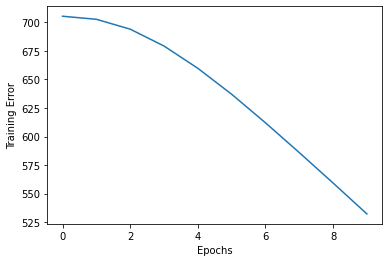

In [27]:
#Model error
#https://github.com/tensorflow/tensorflow/issues/23698


from keras.models import load_model

if os.path.exists('model.h5'):
    model = load_model('model.h5')
else:
    history = model.fit([train.user_id, train.id], train.num_aifs, epochs=10, verbose=1)
    model.save('model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")